In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format


df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).tail()

,date,Italy,US,Spain,Germany,"Korea, South"
845,2022-05-16,17071649,82630509,12127122,25818405,17830429
846,2022-05-17,17116550,82742996,12179234,25890456,17861744
847,2022-05-18,17147477,82951379,12179234,25949175,17889849
848,2022-05-19,17178199,83060959,12179234,25998085,17914957
849,2022-05-20,17205017,83237592,12179234,26040460,17938399


In [23]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
I0=df_analyse.Germany[57]
S0=N0-I0
R0=0

In [24]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

In [25]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

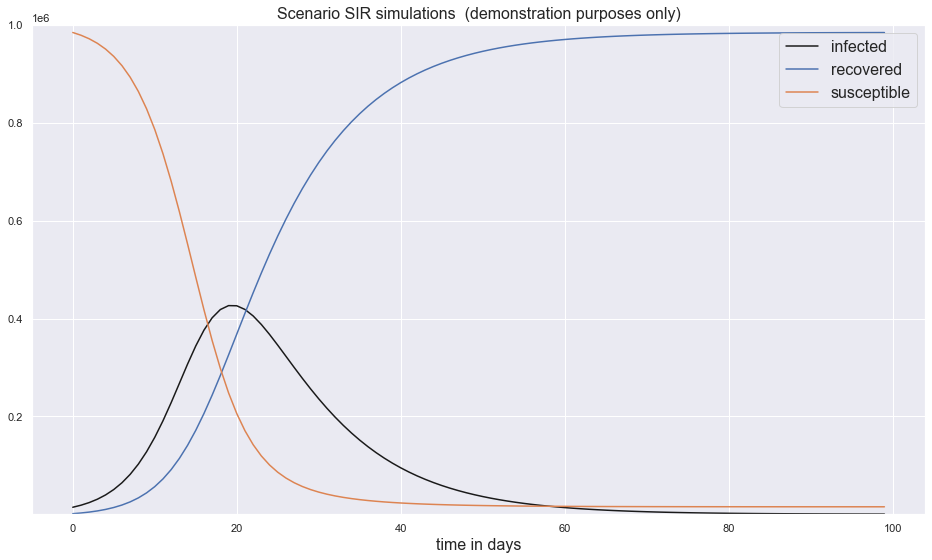

In [27]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Scenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

In [29]:
ydata = np.array(df_analyse.Germany[57:])
t=np.arange(len(ydata))

In [30]:
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [31]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [32]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [33]:
# example curve of our differential equations
popt=[0.6,0.3]
fit_odeint(t, *popt)

array([ 1.09990000e+04,  1.47176389e+04,  1.95907660e+04,  2.58984322e+04,
        3.39310673e+04,  4.39450173e+04,  5.60901863e+04,  7.03114967e+04,
        8.62417714e+04,  1.03125204e+05,  1.19825094e+05,  1.34956977e+05,
        1.47138284e+05,  1.55279392e+05,  1.58806163e+05,  1.57733289e+05,
        1.52581616e+05,  1.44197728e+05,  1.33554114e+05,  1.21587614e+05,
        1.09099206e+05,  9.67112770e+04,  8.48660359e+04,  7.38472997e+04,
        6.38118575e+04,  5.48216749e+04,  4.68724024e+04,  3.99164670e+04,
        3.38806315e+04,  2.86786776e+04,  2.42201421e+04,  2.04160287e+04,
        1.71823019e+04,  1.44418157e+04,  1.21251744e+04,  1.01708951e+04,
        8.52513386e+03,  7.14116223e+03,  5.97871516e+03,  5.00329470e+03,
        4.18547938e+03,  3.50027045e+03,  2.92649142e+03,  2.44624807e+03,
        2.04445057e+03,  1.70839528e+03,  1.42740227e+03,  1.19250321e+03,
        9.96174221e+02,  8.32108164e+02,  6.95021399e+02,  5.80490056e+02,
        4.84811829e+02,  

In [34]:
# the resulting curve has to be fitted
# free parameters are here beta and gammapopt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

standard deviation errors :  [3.26478763e-04 4.72055761e-05]  start infect: 10999
Optimal parameters: beta = 0.02222210697744925  and gamma =  -0.004861441066850934


In [35]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

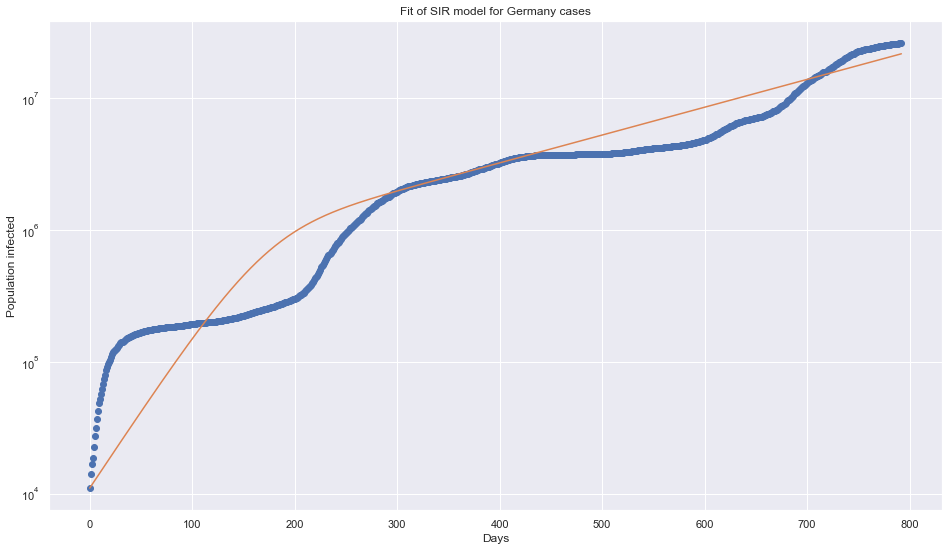

Optimal parameters: beta = 0.02222210697744925  and gamma =  -0.004861441066850934
Basic Reproduction Number R0  -4.571094593530459
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [36]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

End of SIR fit for Germany. 

===========================